# Progetto d'esame del corso Applicazione dell'Intelligenza Artificiale
### Leonardo Bigelli
Sviluppo e studio di Autoencoder per la codifica in TOKEN di elettrocardiogrammi

### Import librerie necessarie per lo sviluppo

In [1]:
!pip install wfdb

In [2]:
import wfdb
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Funzione per scaricare i segnali ECG richiesti
Per comodità, i segnali verranno normalizzati tra 0 e 1

In [3]:
# Funzione per il caricamento di record MIT-BIH.
# Restituisce un tensore (n, m)
# Parametri:
# record_names: lista dei record da scaricare
# pn_dir      : sotto-databased da dove prelevare i dati
# channel     : canale scelto
# normalize   : se True normalizza tra 0 e 1 il segnale
def load_mitbih_records(record_names, pn_dir='mitdb', channel=0, normalize=True, target_length=None):
    signals = []

    # scarica ogni record richiesto
    for rec_name in record_names:
        rec = wfdb.rdrecord(rec_name, pn_dir=pn_dir)
        # tengo in considerazione solamente il canale richiesto
        sig = rec.p_signal[:, channel]
        # normalizzazione, se richiesta
        if normalize:
            mi, ma = sig.min(), sig.max()
            sig = (sig - mi) / (ma - mi)

        signals.append(sig)

    n = len(signals)
    # Se target_length non è fornito, lo calcoliamo come min(len(sig) for sig in signals)
    if target_length is None:
        target_length = min(sig.shape[0] for sig in signals)

    # Troncamento o padding di ogni segnale a target_length.
    # Utile per rendere tutti i record della stessa lunghezza
    processed = []
    for sig in signals:
        if sig.shape[0] >= target_length:
            # Tronco i campioni in eccesso
            proc = sig[:target_length]
        else:
            # Pad con zeri se è più corto
            pad_width = target_length - sig.shape[0]
            proc = np.concatenate([sig, np.zeros(pad_width, dtype=sig.dtype)])
        processed.append(proc)

    data_np = np.stack(processed, axis=0)

    # Conversione nel tensore di pythorch
    data_tensor = torch.from_numpy(data_np).float()

    return data_tensor

In [4]:
record_list = ['100']#, '101', '118', '119', '121']
tensor_ecg = load_mitbih_records(record_list, pn_dir='mitdb', channel=0, normalize=True, target_length=None)
original_signal = tensor_ecg[0, :250].clone()  # fisso
print("Shape del tensore ECG:", tensor_ecg.shape)

Shape del tensore ECG: torch.Size([1, 650000])


### Visualizzazione grafica dei dati scaricati

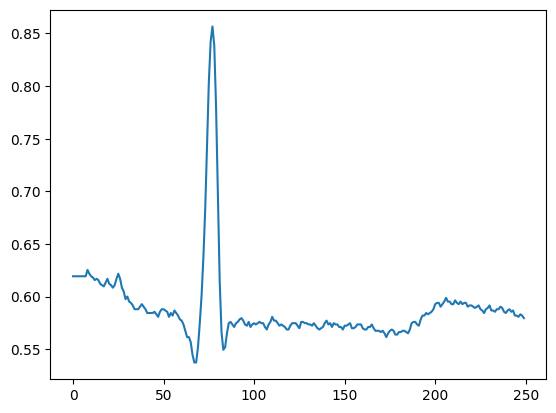

In [5]:
plt.plot(tensor_ecg[0,0:250])
plt.savefig("sequenza_originale.eps")
plt.show()

### Processo di suddivisione in blocchi del segnale di partenza

In [6]:
# divisioni in blocchi
n, m = tensor_ecg.shape
block_size = 250
num_blocks = m // block_size

In [7]:
data_blocks = tensor_ecg[:, :num_blocks * block_size]
data_blocks = data_blocks.view(n, num_blocks, block_size)

# eliminazione dimensione ridondante
data_blocks = data_blocks.squeeze(0)  # (6500, 100)

# print della shape del tensore per un check manuale
print("Shape finale:", data_blocks.shape)

Shape finale: torch.Size([2600, 250])


In [8]:
# divisione in blocchi da dim_block
dim_block = 10
n_signals, n_blocks = data_blocks.shape
data_blocks_10x10 = data_blocks.view(n_signals, block_size//dim_block,  dim_block)

print("Shape dopo suddivisione in blocchi da 10:", data_blocks_10x10.shape)

data_for_training = data_blocks_10x10.view(data_blocks_10x10.shape[0]*(block_size//dim_block), dim_block)
print("Shape finale:", data_for_training.shape)

Shape dopo suddivisione in blocchi da 10: torch.Size([2600, 25, 10])
Shape finale: torch.Size([65000, 10])


In [9]:
# Flatten in [6500 * 10, 10] e aggiungiunta del canale
data_for_loader = data_blocks_10x10.reshape(-1, dim_block).unsqueeze(1)
print("Shape finale:", data_for_loader.shape)

Shape finale: torch.Size([65000, 1, 10])


In [10]:
# Funzione per la suddivisione in train e test del dataset
# Parametri:
# dataset    : set di dati di partenza
# train_frac : perccentuale della porzione di train
# seed       : per rendere deterministico il funzionamento dell'algoritmo
def split_dataset(dataset, train_frac=0.8, seed=42):
    N = len(dataset)
    train_size = int(train_frac * N)
    test_size = N - train_size
    torch.manual_seed(seed)

    return random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(data_for_loader, train_frac=0.8)
print("Train size:", len(train_ds))
print("Test size:", len(test_ds))

Train size: 52000
Test size: 13000


In [11]:
# Creazione dei Loader per l'addestramento della rete
train_loader = DataLoader(train_ds, batch_size=128,
                              shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=128,
                              shuffle=False, drop_last=False)

In [12]:
# Check manuale della shape di un singolo batch
print("Shape del tensore di test_ds:", test_ds[0].shape)

Shape del tensore di test_ds: torch.Size([1, 10])


### Codice per la definizione delle varie architetture degli autoencoder
Segue il codice per diverse architetture provate

In [16]:
# 1° architettura: Tokenizzazione di tutta la serie di 100 elementi in un singolo token
class Conv1dAutoencoder100to1(nn.Module):
    def __init__(self):
        super().__init__()
        # ================== ENCODER ==================
        # Riduce la sequenza da 100 → 50 → 25 → 12 → 5 → 1
        self.encoder = nn.Sequential(
            # 100 → 50
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            # 50 → 25
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            # 25 → 12
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0),
            nn.ReLU(inplace=True),
            # 12 → 5
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0),
            nn.ReLU(inplace=True),
            # 5 → 1
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=5, stride=5, padding=0),
            nn.ReLU(inplace=True)
        )

        # ================== DECODER ==================
        # Ricostruisce la sequenza da 1 → 5 → 12 → 25 → 50 → 100
        self.decoder = nn.Sequential(
            # 1 → 5
            nn.ConvTranspose1d(in_channels=1, out_channels=1,
                               kernel_size=5, stride=5, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 5 → 12  (output_padding=1 per fare 11+1=12)
            nn.ConvTranspose1d(in_channels=1, out_channels=1,
                               kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(inplace=True),
            # 12 → 25  (output_padding=0 per fare 22+3=25)
            nn.ConvTranspose1d(in_channels=1, out_channels=1,
                               kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 25 → 50 (output_padding=0)
            nn.ConvTranspose1d(in_channels=1, out_channels=1,
                               kernel_size=2, stride=2, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 50 → 100 (output_padding=0)
            nn.ConvTranspose1d(in_channels=1, out_channels=1,
                               kernel_size=2, stride=2, padding=0, output_padding=0),
            nn.Sigmoid()  # l’input è normalizzato tra 0 e 1
        )

    def forward(self, x):
        # x: (batch_size, 1, 100)
        latent = self.encoder(x)
        recon  = self.decoder(latent)
        return recon, latent

#####################################################################################################

# 2° architettura: Tokenizzazione di un blocco di 10 elementi in un singolo token
class Conv1dAutoencoder10to1(nn.Module):
    def __init__(self):
        super().__init__()
        # ================== ENCODER ==================
        # Riduce la sequenza da 10 → 8 → 6 → 4 → 2 → 1
        self.encoder = nn.Sequential(
            # 10 → 8
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            # 8 → 6
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            # 6 → 4
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            # 4 → 2
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            # 2 → 1
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True)
        )

        # ================== DECODER ==================
        # Ricostruisce la sequenza da 1 → 2 → 4 → 6 → 8 → 10
        self.decoder = nn.Sequential(
            # 1 → 2
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 2 → 4
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 4 → 6
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 6 → 8
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.ReLU(inplace=True),
            # 8 → 10
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.Sigmoid()  # Output normalizzato tra 0 e 1
        )

    def forward(self, x):
        # x: (batch_size, 1, 10)
        latent = self.encoder(x)
        recon  = self.decoder(latent)
        return recon, latent

# 3° architettura: Tokenizzazione di un blocco di 10 elementi in un singolo token,
# con maggiore espressività della rete
class Conv1dAutoencoder10to1Deep(nn.Module):
    def __init__(self):
        super().__init__()

        # ============== ENCODER: 10 → 1 =================
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1)  # → (B, 32, 1)
        )

        # ============== DECODER: 1 → 10 =================
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose1d(16, 8, kernel_size=5),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.ConvTranspose1d(8, 1, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

'''
#versione 3 con la quantizzazione
# Funzione di quantizzazione con Straight-Through Estimator
def quantize_straight_through(x):
    return (x - x.detach()) + x.detach().round()

class Conv1dAutoencoder10to1Quantized(nn.Module):
    def __init__(self):
        super().__init__()

        # ============== ENCODER ==============
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),   # (B, 1, 10) → (B, 8, 10)
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Conv1d(8, 16, kernel_size=3, padding=1),  # → (B, 16, 10)
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=3, padding=1), # → (B, 32, 10)
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1)  # → (B, 32, 1)
        )

        # ============== DECODER ==============
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),  # → (B, 16, 1)
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),           # → (B, 16, 2)
            nn.ConvTranspose1d(16, 8, kernel_size=5),              # → (B, 8, 6)
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.ConvTranspose1d(8, 1, kernel_size=5),               # → (B, 1, 10)
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)                # z: (B, 32, 1)
        z_q = quantize_straight_through(z)  # quantizzazione con STE
        out = self.decoder(z_q)            # decoder riceve z quantizzato
        return out, z_q
'''
###########################################################################################

# 4° architettura: Tokenizzazione di un blocco di 'n' elementi in un singolo token
class DimReduction(nn.Module):
    def __init__(self):
        super().__init__()

        # ============== ENCODER: 5 → 1 =================
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1)
        )

        # ============== DECODER: 1 → 5 =================
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Upsample(size=3, mode='nearest'),
            nn.ConvTranspose1d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Upsample(size=dim_block, mode='nearest'),
            nn.ConvTranspose1d(8, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


### Addestramento della rete

In [17]:
model = DimReduction() #Conv1dAutoencoder100to1()
# Funzione di perdita
criterion = nn.MSELoss()
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# n° di epoche
epochs = 20
history = {'train_loss': [], 'test_loss': []}

for epoch in range(1, epochs + 1):
  model.train()
  running_train_loss = 0.0
  for batch in train_loader:
      optimizer.zero_grad()
      recon, _ = model(batch)
      loss = criterion(recon, batch)
      loss.backward()
      optimizer.step()
      running_train_loss += loss.item() * batch.size(0)

  running_train_loss /= len(train_loader.dataset)

  # Ciclo di validazione del modello addestrato sopra
  model.eval()
  running_test_loss = 0.0
  with torch.no_grad():
      for batch in test_loader:
          recon, _ = model(batch)
          running_test_loss += criterion(recon, batch).item() * batch.size(0)
  running_test_loss /= len(test_loader.dataset)

  history['train_loss'].append(running_train_loss)
  history['test_loss'].append(running_test_loss)
  print(f"Epoch {epoch}/{epochs}  — Train Loss: {running_train_loss:.6f}  Test Loss: {running_test_loss:.6f}")

Epoch 1/20  — Train Loss: 0.001073  Test Loss: 0.000273
Epoch 2/20  — Train Loss: 0.000316  Test Loss: 0.000146
Epoch 3/20  — Train Loss: 0.000180  Test Loss: 0.000105
Epoch 4/20  — Train Loss: 0.000128  Test Loss: 0.000096
Epoch 5/20  — Train Loss: 0.000100  Test Loss: 0.000058
Epoch 6/20  — Train Loss: 0.000092  Test Loss: 0.000090
Epoch 7/20  — Train Loss: 0.000093  Test Loss: 0.000068
Epoch 8/20  — Train Loss: 0.000077  Test Loss: 0.000065
Epoch 9/20  — Train Loss: 0.000075  Test Loss: 0.000042
Epoch 10/20  — Train Loss: 0.000064  Test Loss: 0.000047
Epoch 11/20  — Train Loss: 0.000066  Test Loss: 0.000043
Epoch 12/20  — Train Loss: 0.000058  Test Loss: 0.000038
Epoch 13/20  — Train Loss: 0.000054  Test Loss: 0.000034
Epoch 14/20  — Train Loss: 0.000051  Test Loss: 0.000050
Epoch 15/20  — Train Loss: 0.000049  Test Loss: 0.000044
Epoch 16/20  — Train Loss: 0.000050  Test Loss: 0.000040
Epoch 17/20  — Train Loss: 0.000048  Test Loss: 0.000039
Epoch 18/20  — Train Loss: 0.000049  Tes

### Validazione vera e propria del modello

In [18]:
# test
# Definisco il criterio MSE
criterion = nn.MSELoss(reduction='sum')

model.eval()
total_mse_test = 0.0
num_samples_test = 0

# Memorizzo i tensori originali e quelli ricostruiti dal modello
# utile per la visualizzazione
originals = []
reconstructions = []

with torch.no_grad():
    for batch in test_loader:
        # batch: shape (batch_size, 1, 100)
        recon_batch, latent_batch = model(batch)
        mse_batch = criterion(recon_batch, batch)
        # somma MSE su tutti i campioni nel batch
        total_mse_test += mse_batch.item()
        num_samples_test += batch.size(0)

        originals.append(batch)
        reconstructions.append(recon_batch)

# MSE medio per blocco nel test set
mse_avg_per_block = total_mse_test / num_samples_test

print("Numero di esempi di test:", num_samples_test)
print(f"MSE medio per blocco nel test set: {mse_avg_per_block:.6f}")


Numero di esempi di test: 13000
MSE medio per blocco nel test set: 0.000356


## Ora che il modello è stato addestrato, prendo una serie temporale e la uso come imput all'autoencoder.
##### Poi confronto i risultati

In [ ]:
# Considero i primi 100 elementi
first_batch = next(iter(test_loader))
print(first_batch.size())
#first_100 = first_batch[:250//dim_block]
first_100 = first_batch[0]
print("Shape del primo batch:", first_100.shape)

# Riordino i 100 in 10 blocchi consecutivi mantenendo l'ordine temporale
blocks10x10 = first_100.view(250//dim_block, 1, dim_block)

# Inference con l’autoencoder già addestrato
model.eval()
with torch.no_grad():
    recon_batch, _ = model(blocks10x10)

# Ricostruisci i 100 elementi concatenando i 10 blocchi ricostruiti
recon_100 = recon_batch.view(250)
original_100 = blocks10x10.view(250)

# Plot serie originale vs ricostruita
plt.figure(figsize=(12, 4))
plt.plot(original_100.cpu(), label='Originale', marker='.')
plt.plot(recon_100.cpu(), label='Ricostruito', marker='.')
plt.title("Confronto tra Originale e Ricostruito")
plt.xlabel("Campioni")
plt.ylabel("Valore normalizzato")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


torch.Size([128, 1, 10])
Shape del primo batch: torch.Size([1, 10])


RuntimeError: shape '[25, 1, 10]' is invalid for input of size 10

torch.Size([250])


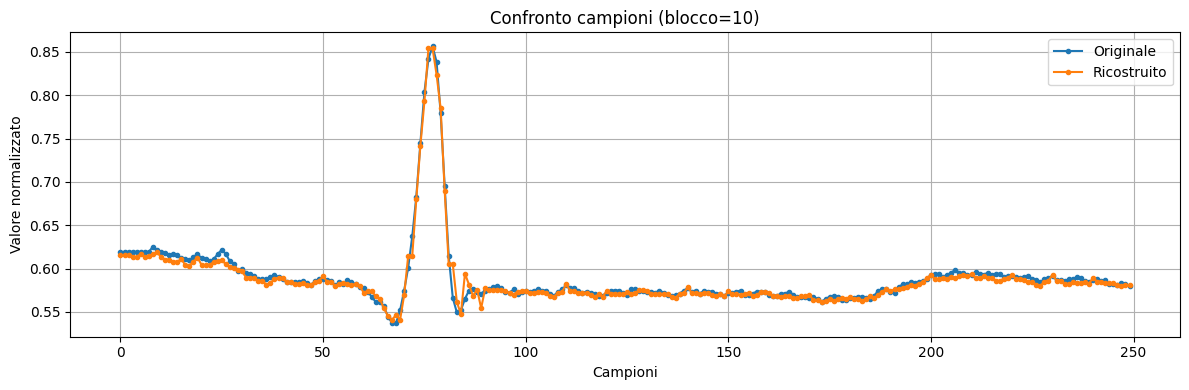

In [19]:
# prova: il blocco sopra non funziona
# Hyperparametri

print(original_signal.shape)
original_blocks = original_signal.view(250//dim_block, 1, dim_block)

#  Passa al modello
model.eval()
with torch.no_grad():
    recon_blocks, _ = model(original_blocks)

# Flatten per confrontare l’intera sequenza
original_250 = original_blocks.view(-1)
recon_250 = recon_blocks.view(-1)

dati_ricostruiti_dim125 = np.copy(recon_250)

plt.figure(figsize=(12, 4))
plt.plot(original_250.cpu(), label='Originale', marker='.')
plt.plot(recon_250.cpu(), label='Ricostruito', marker='.')
plt.title(f"Confronto campioni (blocco={dim_block})")
plt.xlabel("Campioni")
plt.ylabel("Valore normalizzato")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
np.save("dati_2.npy", dati_ricostruiti_dim125)

### Funzione di quantizzazione tratta dal paper "Chronos: Learning the Language of Time Series"
https://doi.org/10.48550/arXiv.2403.07815

In [13]:
# Funzione per la quantizzazione dello spazio latente
# Paramentri:
# x: tensore da quantizzare
# num_bins: numero di token che definirà la grandezza del dizionario
# min_val: valore minimo dello spazio lattente (arbitrario, visto la natura del problema)
# max_val: valore massimo dello spazio lattente (arbitrario, visto la natura del problema)
def quantize(x, num_bins, min_val, max_val):
    # Calcola la larghezza di ciascun bin
    bin_width = (max_val - min_val) / num_bins
    # Quantizza i valori
    q = ((x - min_val) / bin_width).floor().clamp(0, num_bins - 1).to(torch.int64)
    return q


# Funzione per la de-quantizzazione dati dei tokens
# Paramentri:
# x: tensore da de-quantizzare
# num_bins: numero di token che definirà la grandezza del dizionario
# min_val: valore minimo dello spazio lattente (arbitrario, visto la natura del problema)
# max_val: valore massimo dello spazio lattente (arbitrario, visto la natura del problema)
def dequantize(q, num_bins, min_val, max_val):
    # Calcola la larghezza di ciascun bin
    bin_width = (max_val - min_val) / num_bins
    # Calcola i centri dei bin
    centers = min_val + bin_width * (q.float() + 0.5)
    return centers

### Verifica della funzione di quantizzazione realizzata

In [14]:
# Stessa procedura utilizzata per il plot
# first_batch = next(iter(test_loader))
# first_100 = first_batch[:(100//dim_block)]
# print("Shape del primo batch:", first_100.shape)

# input_tensor = first_100.view((100//dim_block), 1, dim_block)

original_blocks = original_signal.view(250//dim_block, 1, dim_block)

model.eval()
with torch.no_grad():
     z = model.encoder(original_blocks)


num_bins = 256
# In questo caso la scelta può non essere arbitraria, solo per il test
min_val = -5#z.min().item()
max_val = +5#z.max().item()

# Quantizza
z_q = quantize(z, num_bins, min_val, max_val)

# De-quantizza
z_dq = dequantize(z_q, num_bins, min_val, max_val)


NameError: name 'model' is not defined

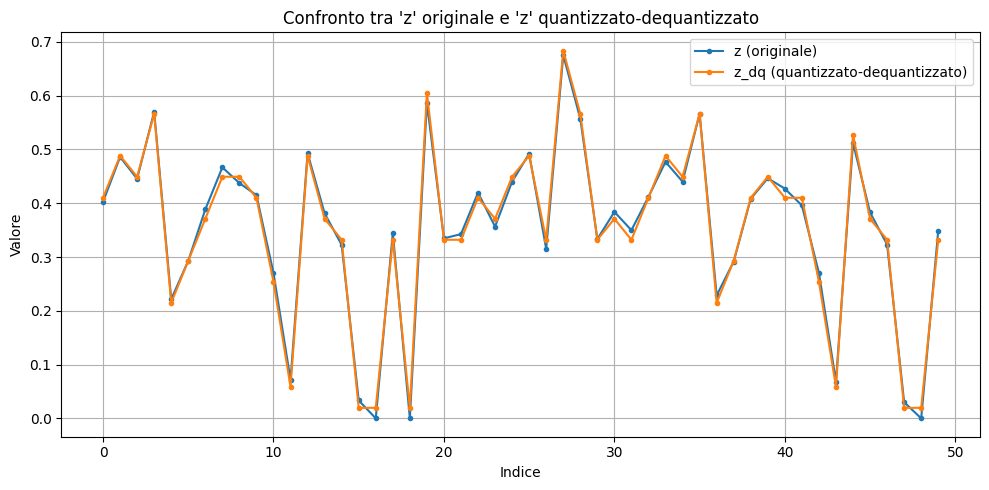

In [ ]:
# Plotta di verifica
plt.figure(figsize=(10, 5))
plt.plot(z.flatten()[:50].cpu(), label='z (originale)', marker='.')
plt.plot(z_dq.flatten()[:50].cpu(), label='z_dq (quantizzato-dequantizzato)', marker='.')
plt.title("Confronto tra 'z' originale e 'z' quantizzato-dequantizzato")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Calcolo MSE tra z e z_dq
mse_z_zdq = torch.mean((z - z_dq) ** 2)

print(f"MSE tra z e z_dq: {mse_z_zdq.item():.6f}")

NameError: name 'z' is not defined

### Implementazione di due layers custun che implementano le funzioni per la quantizzazione

In [15]:

# def quantize(x, num_bins, min_val, max_val):
#     bin_width = (max_val - min_val) / num_bins
#     q = ((x - min_val) / bin_width).floor().clamp(0, num_bins - 1).to(torch.int64)
#     return q

# def dequantize(q, num_bins, min_val, max_val):
#     bin_width = (max_val - min_val) / num_bins
#     centers = min_val + bin_width * (q.float() + 0.5)
#     return centers

# Definizione dei layers custum che implementano le funzioni di quantizzazione
class QuantizeLayer(nn.Module):
    def __init__(self, num_bins, min_val, max_val):
        super().__init__()
        self.num_bins = num_bins
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, x):
        # x: float tensor
        return quantize(x, self.num_bins, self.min_val, self.max_val)

class DequantizeLayer(nn.Module):
    def __init__(self, num_bins, min_val, max_val):
        super().__init__()
        self.num_bins = num_bins
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, q):
        # q: int tensor
        return dequantize(q, self.num_bins, self.min_val, self.max_val)

# Definizione dell'autoencoder con i layers custum sopra definiti
class AutoencoderQuant(nn.Module):
    def __init__(self, num_bins=16, min_val=0.0, max_val=1.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8), nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)   # → (B,32,1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16), nn.ReLU(),
            nn.Upsample(size=3, mode='nearest'),
            nn.ConvTranspose1d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8), nn.ReLU(),
            nn.Upsample(size=dim_block, mode='nearest'),
            nn.ConvTranspose1d(8, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        # layer custom
        self.quant = QuantizeLayer(num_bins, min_val, max_val)
        self.dequant = DequantizeLayer(num_bins, min_val, max_val)

    def forward(self, x):
        z = self.encoder(x)
        q = self.quant(z)
        z_dq = self.dequant(q)
        out = self.decoder(z_dq)
        return out, z, q, z_dq


### Addestramento della rete con layers custom

In [16]:
model = AutoencoderQuant(num_bins=256, min_val=-5.0, max_val=5.0) #Conv1dAutoencoder100to1()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
history = {'train_loss': [], 'test_loss': []}

# addestramento
for epoch in range(1, epochs + 1):
  model.train()
  running_train_loss = 0.0
  for batch in train_loader:
      optimizer.zero_grad()
      out, z, q, z_dq = model(batch)
      loss = criterion(out, batch)
      loss.backward()
      optimizer.step()
      running_train_loss += loss.item() * batch.size(0)

  running_train_loss /= len(train_loader.dataset)

  # validazione
  model.eval()
  running_test_loss = 0.0
  with torch.no_grad():
      for batch in test_loader:
          out, z, q, z_dq = model(batch)
          running_test_loss += criterion(out, batch).item() * batch.size(0)
  running_test_loss /= len(test_loader.dataset)

  history['train_loss'].append(running_train_loss)
  history['test_loss'].append(running_test_loss)
  print(f"Epoch {epoch}/{epochs}  — Train Loss: {running_train_loss:.6f}  Test Loss: {running_test_loss:.6f}")

Epoch 1/20  — Train Loss: 0.001240  Test Loss: 0.000245
Epoch 2/20  — Train Loss: 0.000267  Test Loss: 0.000160
Epoch 3/20  — Train Loss: 0.000167  Test Loss: 0.000126
Epoch 4/20  — Train Loss: 0.000136  Test Loss: 0.000106
Epoch 5/20  — Train Loss: 0.000113  Test Loss: 0.000077
Epoch 6/20  — Train Loss: 0.000102  Test Loss: 0.000059
Epoch 7/20  — Train Loss: 0.000092  Test Loss: 0.000055
Epoch 8/20  — Train Loss: 0.000081  Test Loss: 0.000072
Epoch 9/20  — Train Loss: 0.000080  Test Loss: 0.000048
Epoch 10/20  — Train Loss: 0.000071  Test Loss: 0.000043
Epoch 11/20  — Train Loss: 0.000067  Test Loss: 0.000051
Epoch 12/20  — Train Loss: 0.000066  Test Loss: 0.000042
Epoch 13/20  — Train Loss: 0.000064  Test Loss: 0.000039
Epoch 14/20  — Train Loss: 0.000059  Test Loss: 0.000042
Epoch 15/20  — Train Loss: 0.000058  Test Loss: 0.000040
Epoch 16/20  — Train Loss: 0.000059  Test Loss: 0.000043
Epoch 17/20  — Train Loss: 0.000053  Test Loss: 0.000039
Epoch 18/20  — Train Loss: 0.000054  Tes

### Processo di validazione della nuova rete

In [18]:
# Definizione del MSE
criterion = nn.MSELoss(reduction='sum')

model.eval()
total_mse_test = 0.0
num_samples_test = 0

originals = []
reconstructions = []

with torch.no_grad():
    for batch in test_loader:
        out, z, q, z_dq = model(batch)
        mse_batch = criterion(out, batch)
        total_mse_test += mse_batch.item()
        num_samples_test += batch.size(0)

        originals.append(batch)
        reconstructions.append(out)

mse_avg_per_block = total_mse_test / num_samples_test

print("Numero di esempi di test:", num_samples_test)
print(f"MSE medio per blocco nel test set: {mse_avg_per_block:.6f}")

Numero di esempi di test: 13000
MSE medio per blocco nel test set: 0.000313


## Plot tra originale e autoencoder finale

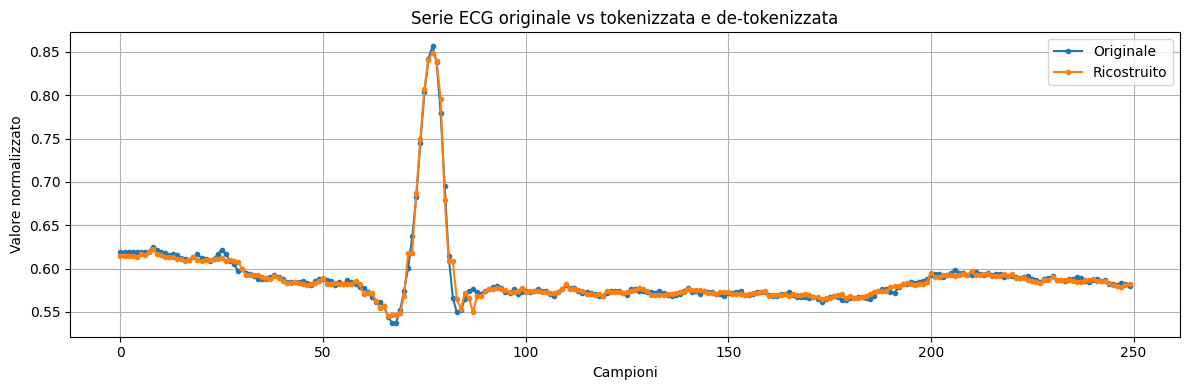

In [19]:
original_blocks = original_signal.view(250//dim_block, 1, dim_block)

# Passa al modello
model.eval()
with torch.no_grad():
    recon_blocks, z, q, z_dq = model(original_blocks)

# Flatten per confrontare l’intera sequenza
original_250 = original_blocks.view(-1)
recon_250 = recon_blocks.view(-1)

dati_ricostruiti_dim125 = np.copy(recon_250)

plt.figure(figsize=(12, 4))
plt.plot(original_250.cpu(), label='Originale', marker='.')
plt.plot(recon_250.cpu(), label='Ricostruito', marker='.')
plt.title("Serie ECG originale vs tokenizzata e de-tokenizzata")
plt.xlabel("Campioni")
plt.ylabel("Valore normalizzato")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("serie_originale_vs_tokenizzata_detokenizzata.eps", format='eps')
plt.show()


## Suddivisione in Tokenizzatore e De-Tokenizzatore

In [20]:
class Tokenizzatore(nn.Module):
    def __init__(self, encoder: nn.Module, quant: nn.Module):
        """
        encoder: modulo nn.Sequential che mappa (B,1,dim_block) → (B,C,1)
        quant:   layer che mappa float → int bins: (B,C,1) → (B,C,1)
        """
        super().__init__()
        self.encoder = encoder
        self.quant = quant

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B,1,dim_block)
        returns: q  (B,C,1)  # interi, dtype=torch.int64
        """
        z = self.encoder(x)
        q = self.quant(z)
        return q


# DeTokenizzatore: dequantizzazione + decoder
class DeTokenizzatore(nn.Module):
    def __init__(self, dequant: nn.Module, decoder: nn.Module):
        """
        dequant: layer che mappa int bins → float centers: (B,C,1) → (B,C,1)
        decoder: modulo nn.Sequential che mappa (B,C,1) → (B,1,dim_block)
        """
        super().__init__()
        self.dequant = dequant
        self.decoder = decoder

    def forward(self, q: torch.Tensor) -> torch.Tensor:
        """
        q: (B,C,1)  # interi
        returns: out (B,1,dim_block)  # ricostruito
        """
        z_dq = self.dequant(q)
        out = self.decoder(z_dq)
        return out

# supponendo model_f = AutoencoderQuant(...) addestrato
# Estrai i sub-moduli
encoder_module = model.encoder
quant_layer     = model.quant
dequant_layer   = model.dequant
decoder_module  = model.decoder

# Instanzia i due modelli
tokenizzatore   = Tokenizzatore(encoder_module, quant_layer)
detokenizzatore = DeTokenizzatore(dequant_layer, decoder_module)

In [23]:
q = tokenizzatore(original_blocks)

# DeTokenizzazione (ricostruzione)
recon = detokenizzatore(q)

criterion = nn.MSELoss()

# Calcolo del MSE medio
mse = criterion(recon, original_blocks)

print(f"MSE tra input e ricostruzione: {mse.item():.6f}")

MSE tra input e ricostruzione: 0.000025


In [ ]:
print(q)

## salvataggio modelli

## Plot a confronto

In [25]:
torch.save(tokenizzatore, "tokenizzatore.pth")
torch.save(detokenizzatore, "detokenizzatore.pth")

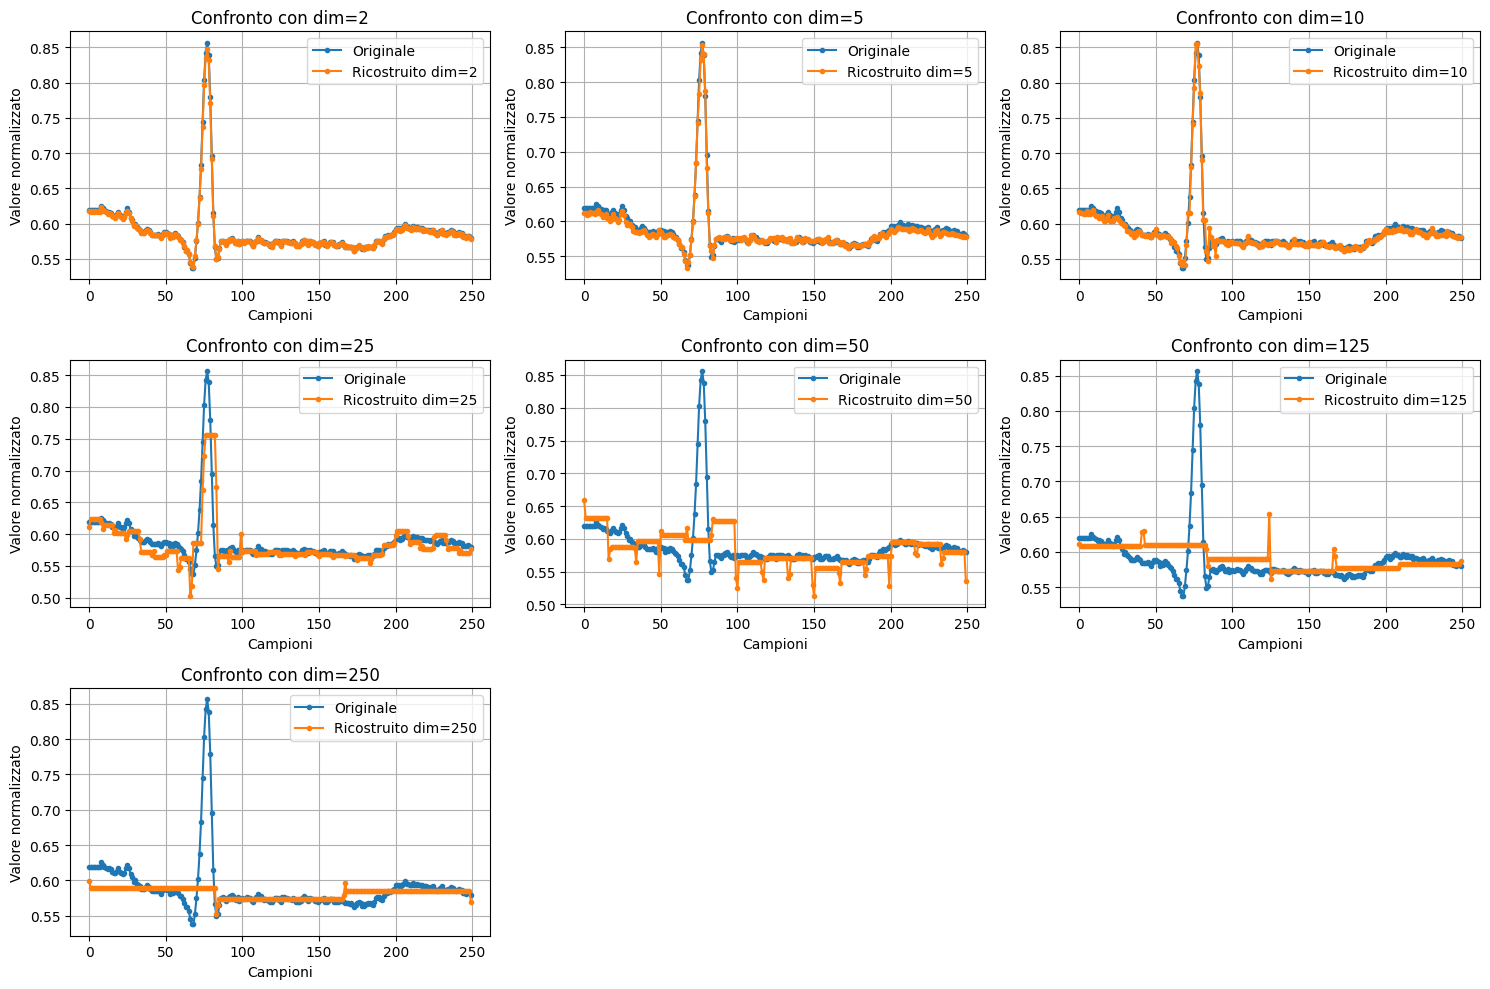

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Caricamento dati
dati_2 = np.load("dati_2.npy")
dati_5 = np.load("dati_5.npy")
dati_10 = np.load("dati_10.npy")
dati_25 = np.load("dati_25.npy")
dati_50 = np.load("dati_50.npy")
dati_125 = np.load("dati_125.npy")
dati_250 = np.load("dati_250.npy")

# Flatten dell'originale
original_250 = original_blocks.view(-1)

# Dati e etichette
dati_lista = [
    (dati_2, "dim=2"),
    (dati_5, "dim=5"),
    (dati_10, "dim=10"),
    (dati_25, "dim=25"),
    (dati_50, "dim=50"),
    (dati_125, "dim=125"),
    (dati_250, "dim=250"),
]

# Creazione subplot 3x3
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for i, (dati, dim_label) in enumerate(dati_lista):
    axs[i].plot(original_250.cpu(), label='Originale', marker='.')
    axs[i].plot(dati, label=f'Ricostruito {dim_label}', marker='.')
    axs[i].set_title(f"Confronto con {dim_label}")
    axs[i].set_xlabel("Campioni")
    axs[i].set_ylabel("Valore normalizzato")
    axs[i].grid(True)
    axs[i].legend()

# Rimuovi i subplot vuoti (le ultime due celle se presenti)
for j in range(len(dati_lista), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("confronto_ricostruzioni.eps", format='eps', bbox_inches='tight')

plt.show()
